### I've been working on fixing the cropping script, to take care of the cases where an observed drifter leaves the domain. In that case, model drifters are released equally for both of the datasets at points inside the domain. But, in some cases, tracks continue outside the domain for one dataset, but stop when they hit the boundry for the other. This leads to an unequal comparison between the sets. For example:

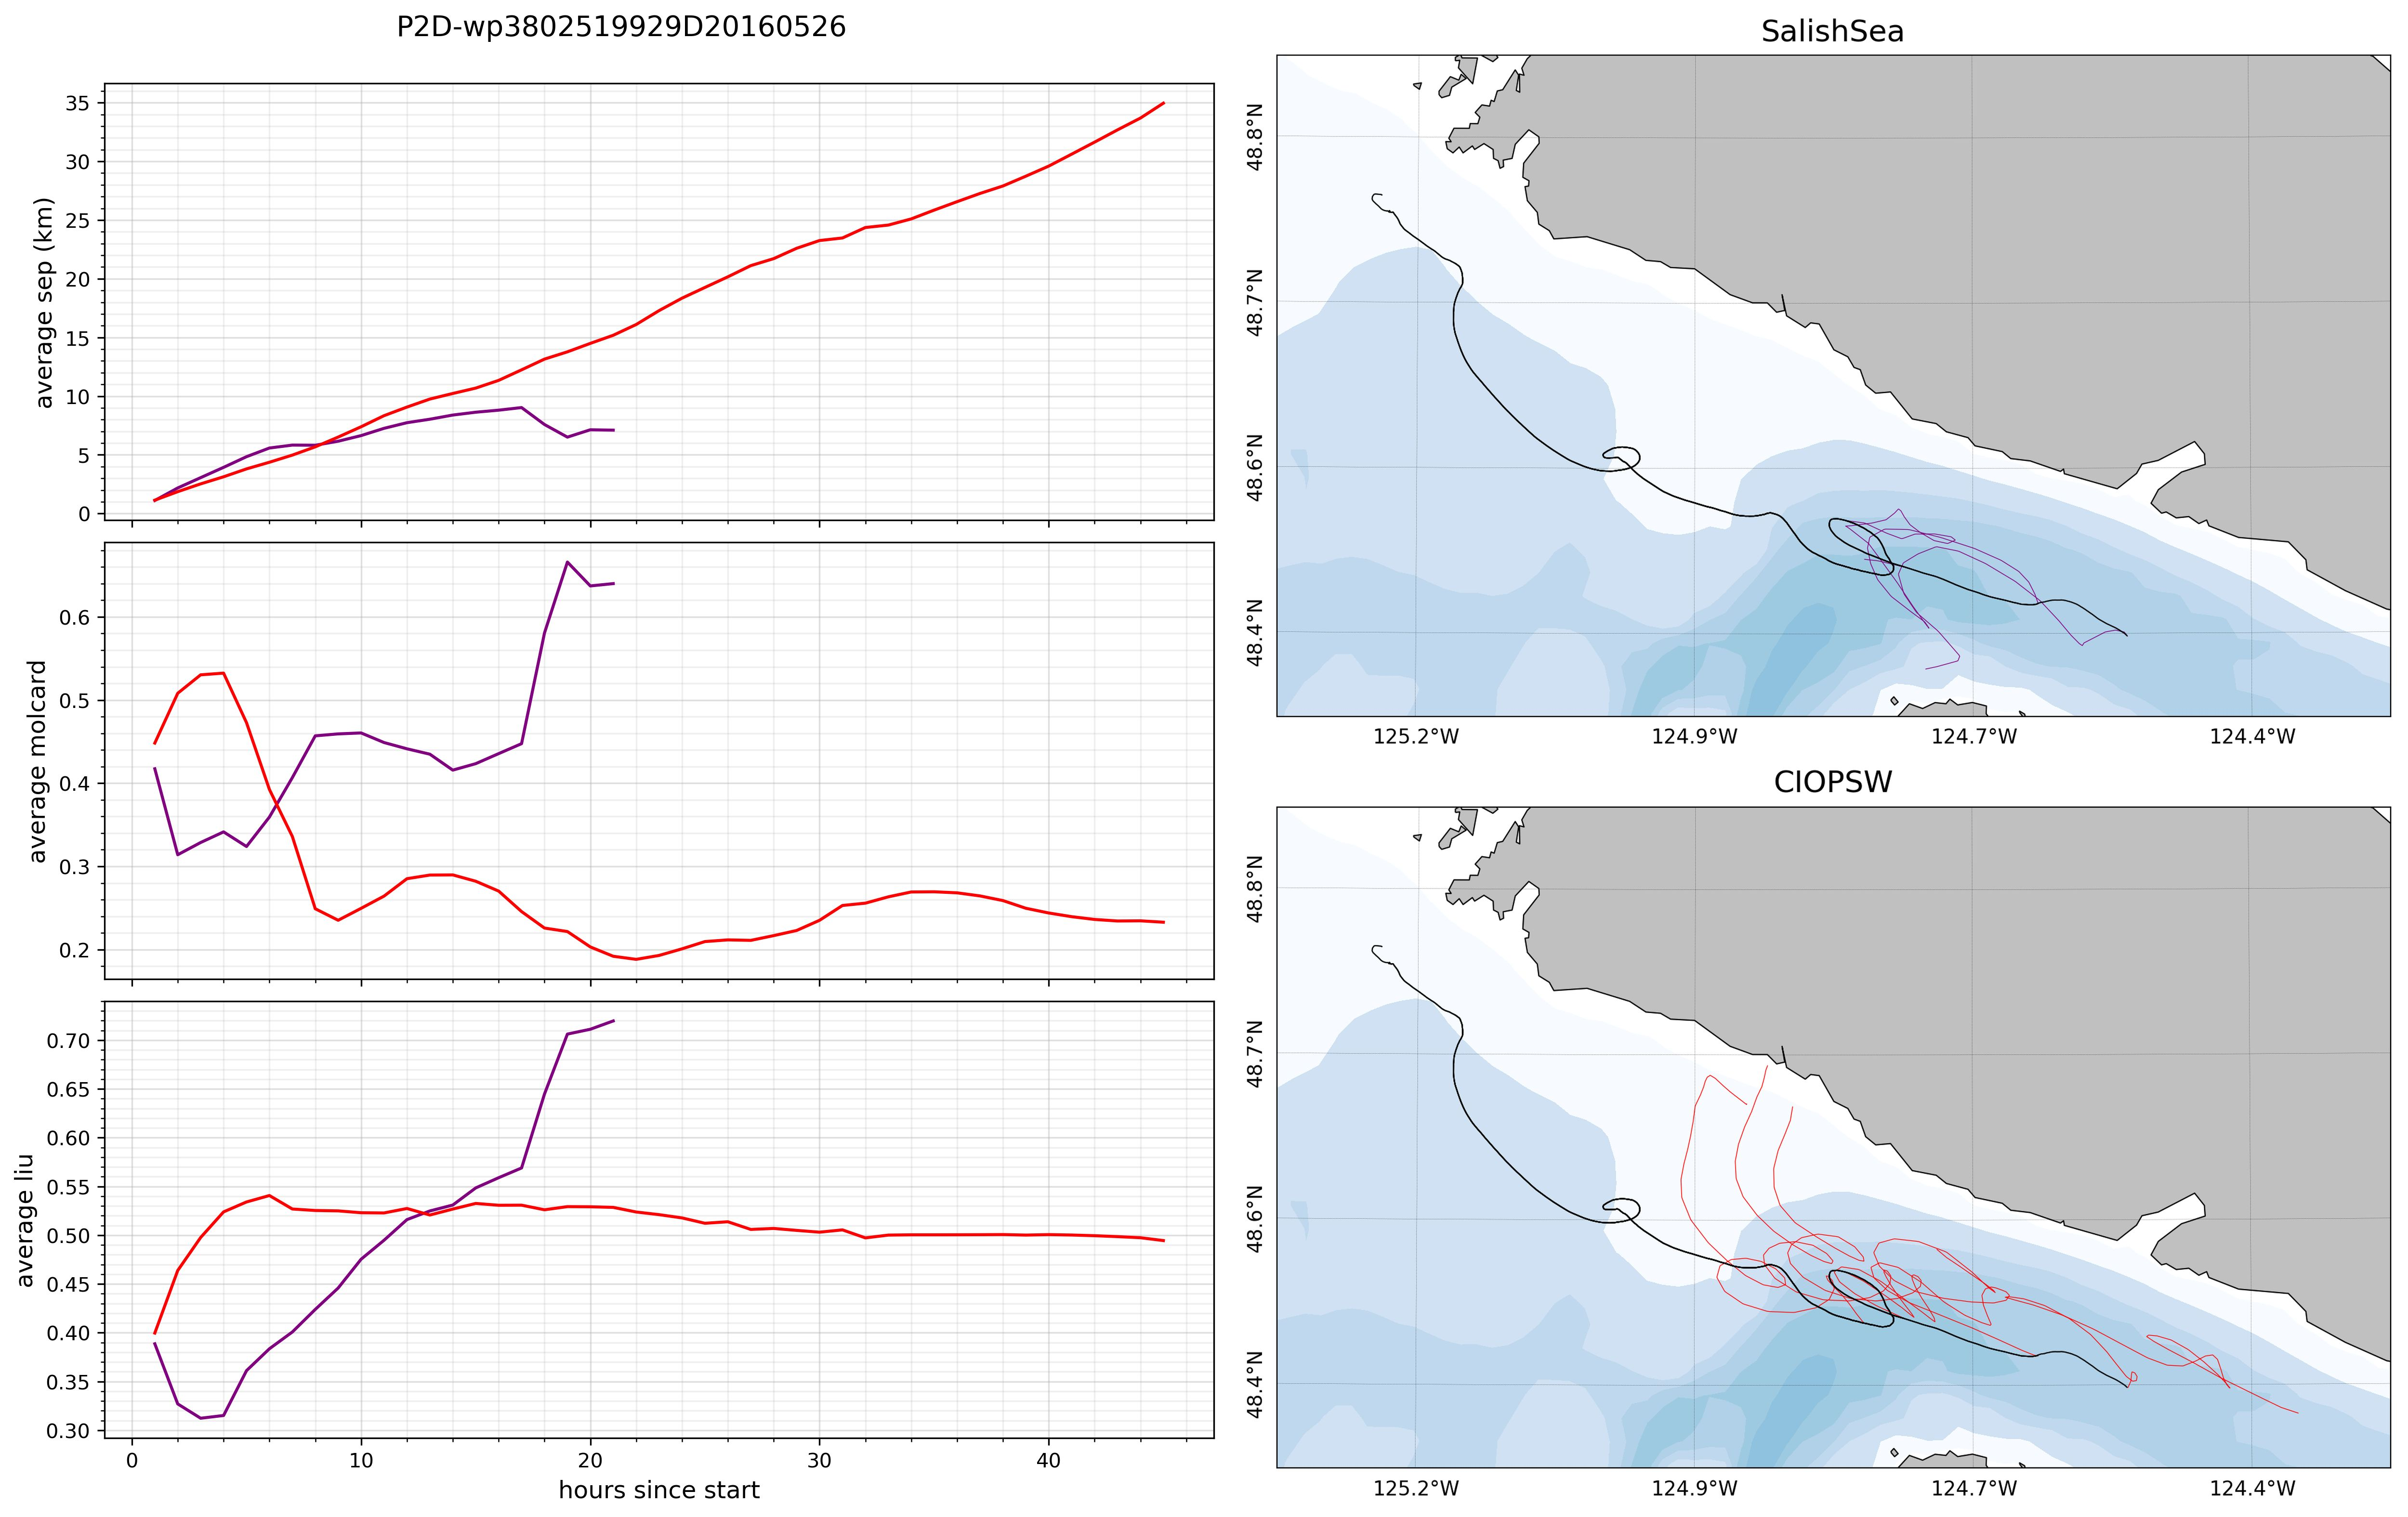

In [39]:
import os, glob
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:/Users/Holdenje/Documents/R/win-library/3.5/sf/proj"
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#the original aggregated files from 
#/gpfs/fs4/dfo/dpnm/dfo_odis/nso001/OPP/SalishSea-N08/hourly-windage2/all_output/output_per_drifter/
salish_aggregated_dir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/individual-sets/SalishSea-hourly_output"
ciopsw_aggregated_dir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/individual-sets/CIOPSW-hourly_output"

#paths to non-aggregated data from 
#/gpfs/fs4/dfo/dpnm/dfo_odis/nso001/OPP/SalishSea-N08/hourly-windage2/all_output/
salish_indv_dir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/non-aggregated_sets/salishsea_non-aggregated_output/"
ciopsw_indv_dir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/non-aggregated_sets/ciopsw_non-aggregated_output/"

#a particular drifter to test
drifterid = 'P2D-wp3802519929D20160526' #'P2D-wp3952528532D20161116'

### Everything was going fine until I found that the lengths of the compareable model tracks between two datasets (ie, finding matching release coordinates) weren't always matching. That meant that I couldn't just apply the nans from one set to the indices of the other set.  Originally, I thought that the model track lengths were consistant within each drifter at least, because they were all the same in the aggregated file (ie, if model_run 1 had a length of 500 timesteps, so does model_run 2). So I thought it was odd that all the model tracks were shorter for output from one dataset but not the other. But, that actually makes sense because the script that aggregates the individual model drifter tracks into one file pads out the values so that all times are account for (there's a time variable that covers all the times in the file). 

### I was curious about how often the difference in lengths was showing up:

In [22]:
#Determine the length of the model tracks for each model track for each drifter. 
#Return the unique track length for each dataset for each drifter.  
def create_len_dict(pathname):
    dict = {}
    for file in glob.glob(os.path.join(pathname,'*.nc')):
        fname = os.path.basename(file).replace('_aggregated.nc','')
        list = []
        with xr.open_dataset(file) as ds:
            for m in ds.model_run.values:
                temp = len(ds['time'][m,:].values.tolist())
                list.append(temp)
            ulist = np.unique(list)
            dict[fname] = ulist[0]
            if len(ulist) != 1:
                print('Why are there more than one track length for this drifter?', fname, ulist)
    return dict

salish_dict = create_len_dict(salish_aggregated_dir)
ciopsw_dict = create_len_dict(ciopsw_aggregated_dir)

#print out the length of the model tracks in any dataset where the length in Salish Sea doesn't match CIOPS-W. 
print('non-matching track lengths')
print('drifterid    SalishSea    CIOPSW')
for i in salish_dict.keys():
    if i in ciopsw_dict.keys():
        if salish_dict[i] != ciopsw_dict[i]:
            print(i, salish_dict[i], ciopsw_dict[i])

non-matching track lengths
drifterid    SalishSea    CIOPSW
P2D-wp3772515323D20160526 556 576
P2D-wp3782516803D20160526 577 578
P2D-wp3802519929D20160526 577 578
P2D-wp3952528532D20161116 411 375
P2D-wp4392522484D20160617 574 575
P2D-wp4422519686D20160617 576 577


### There are a number of cases, so looked at a couple of individual drifters instead. (P2D-wp3802519929D20160526 and P2D-wp3952528532D20161116). The individual model tracks have different lengths when you look at the non-aggregated files, which makes more sense.

In [40]:
def explore_indv_files(pathname, drifterid):
    searchstr = '*' + drifterid + '.nc'
    dict = {}
    for file in glob.glob(os.path.join(pathname, searchstr)):
        fname = os.path.basename(file).split('_')[3].split('.')[0]
        dname = os.path.basename(file).split('_')[2]
        with xr.open_dataset(file) as ds:
            datelength = (ds.time.values[-1]-ds.time.values[0]).astype('timedelta64[h]')
            #print(fname)
            print('  ', dname, ': ', 
                  ds.time.values[0], ds.time.values[-1], 
                  #datelength, 
                  len(ds.time.values))

print(drifterid, '\n')

print('CIOPS-W')
ciopsw_indv = explore_indv_files(ciopsw_indv_dir, drifterid)

print('\nSalish Sea')
salish_indv = explore_indv_files(salish_indv_dir, drifterid)

print('\n','Trying a different drifter','\n')

print('P2D-wp3952528532D20161116', '\n')

print('CIOPS-W')
ciopsw_indv = explore_indv_files(ciopsw_indv_dir, 'P2D-wp3952528532D20161116')

print('\nSalish Sea')
salish_indv = explore_indv_files(salish_indv_dir, 'P2D-wp3952528532D20161116')

P2D-wp3802519929D20160526 

CIOPS-W
   2016052606 :  2016-05-26T06:03:49.000000000 2016-05-28T05:56:28.000000000 576
   2016052612 :  2016-05-26T12:03:22.000000000 2016-05-28T11:56:11.000000000 576
   2016052618 :  2016-05-26T18:03:02.000000000 2016-05-28T17:56:18.000000000 575
   2016052700 :  2016-05-27T00:02:27.000000000 2016-05-28T23:55:32.000000000 575
   2016052706 :  2016-05-27T06:02:57.000000000 2016-05-29T05:55:07.000000000 575
   2016052712 :  2016-05-27T12:02:20.000000000 2016-05-29T11:59:36.000000000 576
   2016052718 :  2016-05-27T18:02:16.000000000 2016-05-29T17:58:40.000000000 577
   2016052800 :  2016-05-28T00:01:32.000000000 2016-05-29T23:57:58.000000000 577
   2016052806 :  2016-05-28T06:01:26.000000000 2016-05-30T05:57:57.000000000 577
   2016052812 :  2016-05-28T12:01:13.000000000 2016-05-30T11:57:20.000000000 577
   2016052818 :  2016-05-28T18:01:18.000000000 2016-05-30T17:57:20.000000000 578
   2016052900 :  2016-05-29T00:00:30.000000000 2016-05-30T23:57:35.000000

### Conclusion: This is all making a bit more sense to me now so I'm able to finish the cropping script. I've added a check in the cropping script to make sure that the timestamps in the files are always matching just in case (I didn't hit any cases where the shorter length didn't come from the end of the track being missing though). And I'm being a bit more specific about how the NaNs get applied to the sets to mask out data when one dataset has tracks that end early.

In [43]:
def plot_aggregated_file(pathname, drifterid):
    searchstr = '*' + drifterid + '_aggregated.nc'
    colors = ['b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink','b','g','r','gray','y','m','purple','pink']
    for file in glob.glob(os.path.join(pathname, searchstr)):
        fname = os.path.basename(file).replace('_aggregated.nc','')
        with xr.open_dataset(file) as ds:
            
            exlats = []
            exlons = []
            for m in ds.model_run.values:
                exlats.append(ds.obs_lat[m,:].values) 
                exlats.append(ds.mod_lat[m,:].values)
                exlons.append(ds.obs_lon[m,:].values) 
                exlons.append(ds.mod_lon[m,:].values)
            
            fig, ax = plt.subplots(1,1,figsize=(15,8))
            map = Basemap(projection='merc', llcrnrlon=np.nanmin(exlons)-0.005, 
                          urcrnrlon=np.nanmax(exlons)+0.005, llcrnrlat=np.nanmin(exlats)-0.005, 
                          urcrnrlat=np.nanmax(exlats)+0.005, resolution='f', ax=ax)

            for m in ds.model_run.values:
                x,y = map(ds.obs_lon[m,:].values, ds.obs_lat[m,:].values)
                mx,my = map(ds.mod_lon[m,:].values, ds.mod_lat[m,:].values)

                #map.plot(mx, my, '.', color=colors[m], zorder = 1, markersize=1)
                map.plot(x, y, 'k.', zorder = 10, markersize=2)
                map.plot(mx, my, color=colors[m], zorder = 1)
            
            map.drawcoastlines()
            map.fillcontinents()
            plt.show()

#print('CIOPS-W')
#plot_aggregated_file(salish_aggregated_dir, 'P2D-wp3952528532D20161116') #drifterid)
#print('\nSalish Sea')
#plot_aggregated_file(ciopsw_aggregated_dir, 'P2D-wp3952528532D20161116') #drifterid)
